Importing Libraries

In [4]:
# Working with arrays
import numpy as np

# Data Analysis & Manipulation
import pandas as pd
import datetime as dt

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

# Scaling
from sklearn.preprocessing import scale

# KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Formating table
from google.colab import data_table
data_table.enable_dataframe_formatter()

from operator import attrgetter

import calendar

Data Injestion

In [5]:
df = pd.read_excel('Online_Retail.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceNo': str},
                   parse_dates=['InvoiceDate'],)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Data Inspection and Cleaning

In [6]:
# No. of Rows and Columns in the dataset
df.shape

(541909, 8)

In [7]:
# Descriptive analysis of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


In [8]:
# Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


From the info above, there some missing values in the "Description" and "CustomerID" columns. lets confirm how mmany below.

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
# % of missing values
(df.isnull().sum()/df.shape[0])*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Handling Missing values
- As shown above 24% of customer ID and 0.27% are non-existence, given that the Customer ID is a unique identifier for customers and description provides details about product, the ideal handling method would be to drop the rows.

In [11]:
#dropping the na rows into a new dataframe
df_clean = df.dropna()

In [12]:
#confirm missing value removal
(df_clean.isnull().sum()/df_clean.shape[0])*100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [13]:
# compare the clean and unclean data
print("the shape of data without missing values is", df_clean.shape)
print("the shape of data with missing values is", df.shape)

the shape of data without missing values is (406829, 8)
the shape of data with missing values is (541909, 8)


Customer order insight

In [14]:
# Customers with multiple orders
n_of_orders = df_clean.groupby(['CustomerID'])['InvoiceNo'].nunique()
cust_wit_mult_orders = np.sum(n_of_orders > 1) / df['CustomerID'].nunique()
print(f'{100 * cust_wit_mult_orders:.2f}% of customers ordered more than once.')

69.97% of customers ordered more than once.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


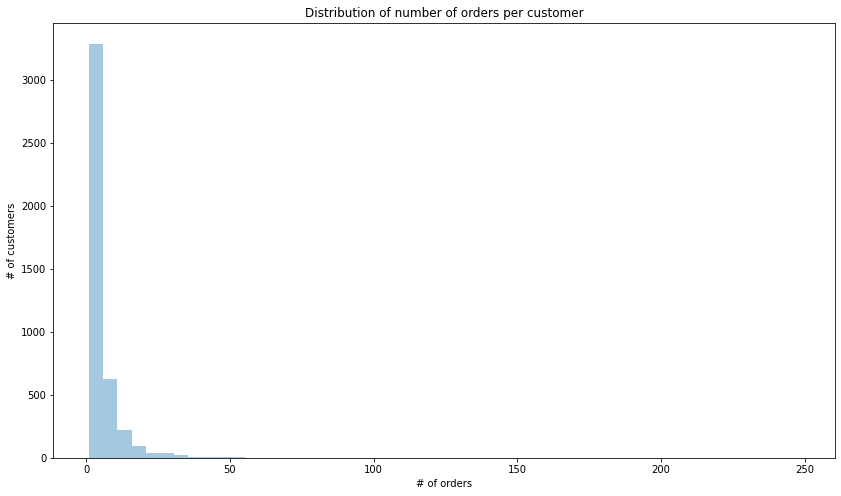

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.distplot(n_of_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

Cohort Analysis

In [16]:
# keeping relevant columns & drop duplicates
# put in new dataframe
df_cha = df_clean[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
df_cha.head()

,CustomerID,InvoiceNo,InvoiceDate
0,17850,536365,2010-12-01 08:26:00
7,17850,536366,2010-12-01 08:28:00
9,13047,536367,2010-12-01 08:34:00
21,13047,536368,2010-12-01 08:34:00
25,13047,536369,2010-12-01 08:35:00


In [17]:
#check chape with duplicates removed
df_cha.shape

(22221, 3)

In [18]:
# create the cohort and order_month variables
df_cha['OrderMonth'] = df_cha['InvoiceDate'].dt.to_period('M')
df_cha['Cohort'] = df_cha.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_cha.head()

,CustomerID,InvoiceNo,InvoiceDate,OrderMonth,Cohort
0,17850,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047,536369,2010-12-01 08:35:00,2010-12,2010-12


In [19]:
#df_cha.drop(['order_month', 'cohort'], axis=1, inplace=True)

In [20]:
# aggregate the data per cohort and order_month and 
# count the number of unique customers (NoOfCustomers) in each group
# add the MonthlyPeriod as the number of periods 
# between the cohort month and the month of the purchase.
df_cohort = df_cha.groupby(['Cohort', 'OrderMonth']) \
              .agg(NoOfCustomers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['MonthlyPeriod'] = (df_cohort.OrderMonth - df_cohort.Cohort).apply(attrgetter('n'))
df_cohort.head()

,Cohort,OrderMonth,NoOfCustomers,MonthlyPeriod
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4


In [23]:
# Getting number of customer for each cohort &
# the monthly period between the cohort in wihich they belong based on first purchase &
# another purchase with the 12 months duration of the dataset
cohort_pivot = df_cohort.pivot_table(index = 'Cohort',
                                     columns = 'MonthlyPeriod',
                                     values = 'NoOfCustomers')
cohort_pivot

MonthlyPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
cohort_size = cohort_pivot.iloc[:,0] #making column 0 the cohort_size, ALL rows, column 0
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) #Divide each column cell by the cohort_size
retention_matrix

MonthlyPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note on Retention Analysis
- Cohort group is based on the month of first purchase. The MonthlyPeriod row is the months following the month of first purchase (cohort), the corresponding data under each MonthlyPeriod column shows the number of customers that make purchases in those following months as a fraction of the total customers that are grouped into that cohort. Retention is the division of the number of customers in the following months divided by the number of customers in the Cohort.

In [26]:
#fig, ax = plt.subplots(figsize=(12, 8))
#sns.heatmap(retention_matrix, 
                #mask=retention_matrix.isnull(), 
                #annot=True, 
                #fmt='.0%', 
                #cmap='RdYlGn');

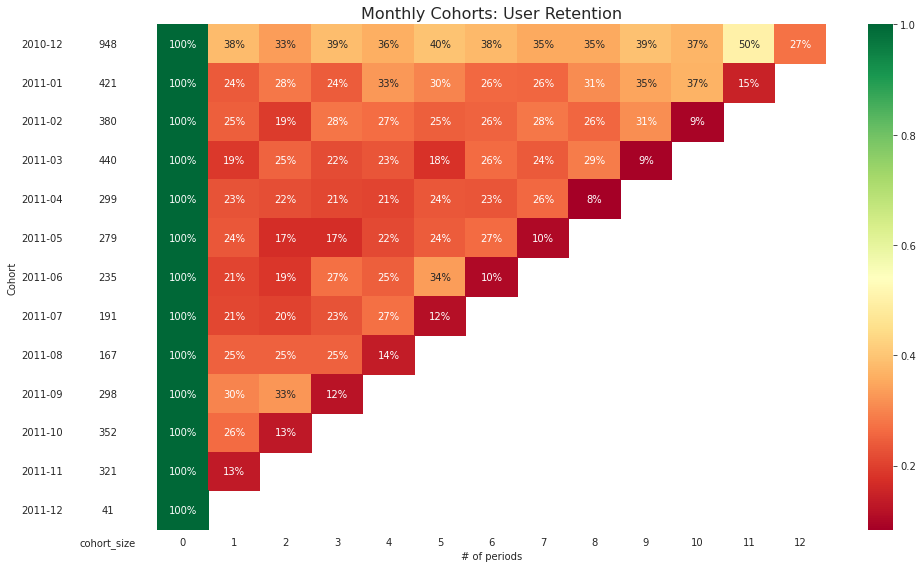

In [25]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Analyzing the Retention Matrix
- The heatmap shows a sharp drop in purchases in the second month represented  in index 1 
- About 80% of customers do not make any purchase in the second month. 
- Except for the first cohort (2010–12) that performs surprisingly well as compared to the other ones. A year after the first purchase, there is a 50% retention.
- The first cohort deserves stakeholders attention, it might be a cohort of dedicated customers, who first joined the platform based on some already-existing connections with the retailer. Although, we cant be certain given the dataset alone.
- The fluctuations in the retention matrix over time could be because of the the business model in which clients do periodic purchases, followed by periods of inactivity.